Este *notebook* representa um pouco do estudo de ciência de dados a partir [deste *dataset*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) do Kaggle. A maior parte do que aprendi foi baseado na explicação adquirida a partid [deste *notebook*](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook). Muitos conceitos são explorados neste *notebook*, alguns sendo de estatística, outros de aprendizado de máquina e inteligência artificial. Alguns *insights* também são tirados a partir do meu conhecimento teórico que adquiri na minha graduação de Ciência da Computação.

In [173]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler

In [174]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,6]
sns.set(style="darkgrid")

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [175]:
X = pd.read_csv('train.csv')

In [176]:
train_ID = X['Id']

X.drop('Id', axis = 1, inplace = True)

## Funções que serão necessárias durante o código


In [148]:
def unique(list1):
     
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))

    if(all(isinstance(n, not str)) for n in unique_list):
        
        unique_list = [item for item in unique_list if not(pd.isnull(item)) == True]
    
    return unique_list, len(unique_list)

def counterElements(lista):

    auxLista, _ = unique(lista)

    dicio = dict.fromkeys(auxLista, 0)
    dicio['NaN'] = 0

    for i, value in enumerate(auxLista):
        
        counter = 0

        for j in range(len(lista)):

            if lista[j] == auxLista[i]:

                counter += 1
    
        dicio[value] = counter

    dicio['NaN'] = lista.isna().sum()

    return dicio

def createColumnsWNaN(lista):

    totalSum = 0
    columnsWNaN = []

    #keys = X.keys()

    for column in lista:
        
        nullElements = X[column].isnull().sum()

        if(nullElements):
            columnsWNaN.append(column)
            totalSum+=1

    if(totalSum > 1):

        print('There are {} relevant columns in with one or more "NaN" as values: {}'.format(totalSum, columnsWNaN))

    else:
        print('There is 1 relevant column in with one or more "NaN" as values: {}'.format(columnsWNaN))

    return columnsWNaN

def createPercentageOfMissingValues(lista):
    percentColumnWNaN = {}
    totalColumnWNan = {}

    for column in lista:

        if(X[column].isnull().sum() > 0):

            percentColumnWNaN[column] = (X[column].isnull().sum() / len(X[column])) * 100
            totalColumnWNan[column] = X[column].isnull().sum()

    dfPercent = pd.DataFrame(list(percentColumnWNaN.items()), columns = ['Feature', 'Faltantes %'])

    dfPercent['Faltantes Total'] = dfPercent['Feature'].map(totalColumnWNan)

    dfPercent = dfPercent.sort_values(by = ['Faltantes %'], ascending = False)

    return dfPercent

def createHistPlot(feature):

    mean = feature.mean()
    median = feature.median()

    plt.axvline(mean, color = 'r', linestyle = '-')
    plt.axvline(median, color = 'g', linestyle = '-')

    sns.histplot(feature, kde = True)

    print('Assimetria: {}'.format(feature.skew()))

    print('Curtose: {}'.format(feature.kurt()))

    plt.legend({'Média': mean,'Mediana': median})

def createProbPlot(feature):
    stats.probplot(feature, plot=plt)


## Informações da saída do dataset 



In [149]:
print(X['SalePrice'].describe())

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64


Com essas informações, pode-se montar o histograma para a análise dos dados. Algo importante para se ter em conta é que não existe o valor 0 nesse *output*, que atrapalharia o modelo regressor, nada que não pudesse ser tratado, como é explicado em [*Medium, Zero-Inflated Regression*](https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af).

## Criando um *heatmap* 

Com o *heatmap*, pode-se analisar como as categorias se relacionam. Quanto mais próximo do vermelho, mais a correlação de categorias é diretamente proporcional. De outra forma, as correlações próximas do azul escuro representam catgegorias inversamente proporcionais se relacionando. Correlações próximas do cinza representam como as categorias não se influenciam. A categoria-alvo que o modelo predirá é *SalePrice*, que representa o valor de venda de uma casa.  

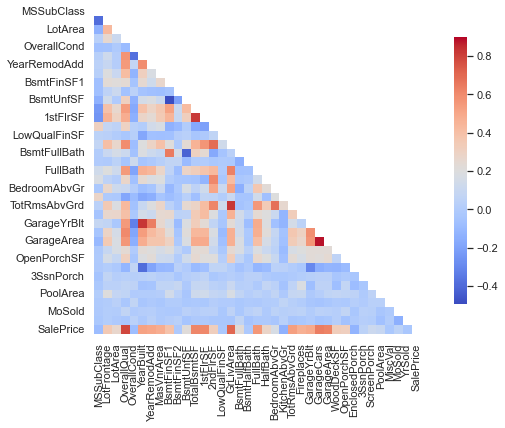

In [150]:
correlation = X.corr()

mask = np.zeros_like(correlation)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):

    f, ax = plt.subplots()

    sns.heatmap(correlation, mask = mask, ax = ax, cbar_kws = {'shrink' : .82},
                vmax = .9, cmap = 'coolwarm', square = True)

## Deletando colunas com valores faltantes

Deve-se deletar o que não for útil para o modelo regressor utilizar para gerar o resultado, e qualquer coluna com mais que 15% de elementos não preenchidos, não é necessário.

In [151]:
columns = X.columns.tolist()

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

         Feature  Faltantes %  Faltantes Total
16        PoolQC        99.52             1453
18   MiscFeature        96.30             1406
1          Alley        93.77             1369
17         Fence        80.75             1179
10   FireplaceQu        47.26              690
0    LotFrontage        17.74              259
11    GarageType         5.55               81
12   GarageYrBlt         5.55               81
13  GarageFinish         5.55               81
14    GarageQual         5.55               81
15    GarageCond         5.55               81
6   BsmtExposure         2.60               38
8   BsmtFinType2         2.60               38
7   BsmtFinType1         2.53               37
5       BsmtCond         2.53               37
4       BsmtQual         2.53               37
3     MasVnrArea         0.55                8
2     MasVnrType         0.55                8
9     Electrical         0.07                1


Agora, deve-se deletar qualquer coluna com mais do que 15% dos elementos não preenchidos.

In [152]:
deletedColumns = []

columns = list(dfPercent['Feature'])

deletedColumns = [dfPercent['Feature'][index] for index, _ in enumerate(columns) if dfPercent['Faltantes %'][index] >= 15]

X.drop(columns = deletedColumns, axis = 1, inplace = True)

Agora, checa-se os elementos que sobraram após a remoção de colunas.

In [153]:
columns = X.columns.tolist()

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

         Feature  Faltantes %  Faltantes Total
8     GarageType         5.55               81
9    GarageYrBlt         5.55               81
10  GarageFinish         5.55               81
11    GarageQual         5.55               81
12    GarageCond         5.55               81
4   BsmtExposure         2.60               38
6   BsmtFinType2         2.60               38
2       BsmtQual         2.53               37
3       BsmtCond         2.53               37
5   BsmtFinType1         2.53               37
0     MasVnrType         0.55                8
1     MasVnrArea         0.55                8
7     Electrical         0.07                1


Algumas colunas que se relacionam contém a mesma quantidade de valores faltantes, como, por exemplo, as colunas "*Garage*" + alguma coisa, contém exatos 81 elementos valores cada. Talvez, esses valores sejam do mesmo elemento. Melhor confirmar essa afirmação, e, se for verdade, deve-se excluir estes elementos. 

In [154]:
garageColumns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

rows = []

[rows.append(X.loc[pd.isna(X[i]), :].index) for i in garageColumns]    

first = rows[0]

[print((np.array(i) == np.array(first)).all()) for i in rows[1:]]
  

True
True
True
True


[None, None, None, None]

As suspeitas se confirmaram: são todos os mesmos elementos. Logo, os mesmos serão excluidos do conjunto de dados.

In [155]:
X.dropna(subset = garageColumns, inplace = True)

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

        Feature  Faltantes %  Faltantes Total
4  BsmtExposure         2.25               31
6  BsmtFinType2         2.25               31
2      BsmtQual         2.18               30
3      BsmtCond         2.18               30
5  BsmtFinType1         2.18               30
0    MasVnrType         0.58                8
1    MasVnrArea         0.58                8
7    Electrical         0.07                1


A ideia é continuar com as colunas relacionadas e ir eliminando os elementos, caso sejam os mesmos com valores faltantes. Agora, segue-se analisando as colunas "*Bsmt*".

In [156]:
BsmtColumns = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']

rows = []

[rows.append(X.loc[pd.isna(X[i]), :].index) for i in BsmtColumns]  

[None, None, None, None, None]

Esse tipo de coluna têm uma pequena diferença: As duas primeiras contém um elemento a mais que as últimas três. Checa-se, então, as duas primeiras, depois as três últimas separadamente.

In [157]:
print(f'First comparison: {((np.array(rows[0]) == np.array(rows[1])).all())}')

first = rows[2]

print('Second comparison:')
for i in rows[3:]:
    print((np.array(i) == np.array(first)).all())

First comparison: False
Second comparison:
True
True


As primeiras duas colunas têm elementos diferentes com valores faltantes. Quantos e quais são?

In [158]:
list_difference = [item for item in rows[0] if item not in rows[1]]

print(list_difference)

[948]


O elemento de índice 948 tem a coluna "BsmtExposure" não preenchida, logo, será removido. Não se pode, também, esquecer de remover o índice diferente da lista de valores que foi criada.

In [159]:
X.drop(list_difference, inplace = True)

print(rows[0])

list(rows[0]).remove(list_difference[0])

Int64Index([  17,   90,  102,  156,  182,  259,  342,  362,  371,  392,  532,
             553,  646,  736,  749,  778,  868,  894,  897,  948,  984, 1000,
            1035, 1045, 1048, 1049, 1090, 1216, 1232, 1321, 1412],
           dtype='int64')


Agora, é necessário saber qual elemento está na coluna "BsmtFinType2" mas não em "BsmtExposure".

In [160]:
list_difference = [item for item in rows[1] if item not in rows[0]]

print(list_difference)

[332]


O elemento de índice 332 tem a coluna "BsmtFinType2" não preenchida, logo, será removido. O índice também será removido da lista.

In [161]:
X.drop(list_difference, inplace = True)

list(rows[1]).remove(list_difference[0])

Agora, checa-se se todos os elementos faltantes das colunas do tipo "Bsmt" são os mesmos, agora que são a mesma quantidade de elementos faltantes.

In [162]:
rows = []

[rows.append(X.loc[pd.isna(X[i]), :].index) for i in BsmtColumns]  

[print((np.array(i) == np.array(first)).all()) for i in rows[1:]]

True
True
True
True


[None, None, None, None]

Todos os elementos faltantes são os mesmos. Pode-se, agora, removê-los.

In [163]:
X.dropna(subset = BsmtColumns, inplace = True)

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

      Feature  Faltantes %  Faltantes Total
0  MasVnrType         0.59                8
1  MasVnrArea         0.59                8
2  Electrical         0.07                1


Falta, agora, remover os elementos das colunas "MasVnr". Checa-se se todos os elementos são os mesmos.

In [164]:
masVnrColumns = ['MasVnrType', 'MasVnrArea']

rows = []

[rows.append(X.loc[pd.isna(X[i]), :].index) for i in masVnrColumns]  

first = rows[0]

[print((np.array(i) == np.array(first)).all()) for i in rows[1:]]

True


[None]

Todos os elementos são iguais, pode-se, então, removê-los.

In [165]:
X.dropna(subset = masVnrColumns, inplace = True)

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

      Feature  Faltantes %  Faltantes Total
0  Electrical         0.07                1


Sobrou somente 1 elemento faltante, que é um com a coluna "Electrical" não preenchida. Esse elemento será removido.

In [166]:
index = X.loc[pd.isna(X['Electrical']), :].index

X.drop(index, inplace = True)

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

Empty DataFrame
Columns: [Feature, Faltantes %, Faltantes Total]
Index: []


Finalmente, todos os elementos com valores não preenchidos foram removidos.

## Análise de correlações

No *heatmap*, pode-se ver que algumas correlações com *SalePrice* estão em vermelho, indicando que são as categorias mais relevantes para se considerar antes de utilizar o modelo regressor. É, então, selecionado todas as categorias que se correlacionam com *SalePrice* com um valor maior que 0.4.

In [167]:
feature = list(correlation.columns)

values = correlation.values

corrList = []

corrDict = {}

for i, val in enumerate(values[36]):

    if(val > 0.4 and feature[i] != 'SalePrice'):

        corrList.append(feature[i])
        corrDict[feature[i]] = val
        print('SalePrice and {} correlates with value {}.'.format(feature[i], "{:.2f}".format(val)))

print('Total features related to SalePrice: {}'.format(len(corrList)))

SalePrice and OverallQual correlates with value 0.79.
SalePrice and YearBuilt correlates with value 0.52.
SalePrice and YearRemodAdd correlates with value 0.51.
SalePrice and MasVnrArea correlates with value 0.48.
SalePrice and TotalBsmtSF correlates with value 0.61.
SalePrice and 1stFlrSF correlates with value 0.61.
SalePrice and GrLivArea correlates with value 0.71.
SalePrice and FullBath correlates with value 0.56.
SalePrice and TotRmsAbvGrd correlates with value 0.53.
SalePrice and Fireplaces correlates with value 0.47.
SalePrice and GarageYrBlt correlates with value 0.49.
SalePrice and GarageCars correlates with value 0.64.
SalePrice and GarageArea correlates with value 0.62.
Total features related to SalePrice: 13


In [168]:
updatedCorrelation = corrList

updatedCorrelation.append('SalePrice')

Com as correlações, pode-se ver melhor a forma em que cada categoria se relaciona com *SalePrice*. 

<function matplotlib.pyplot.show(close=None, block=None)>

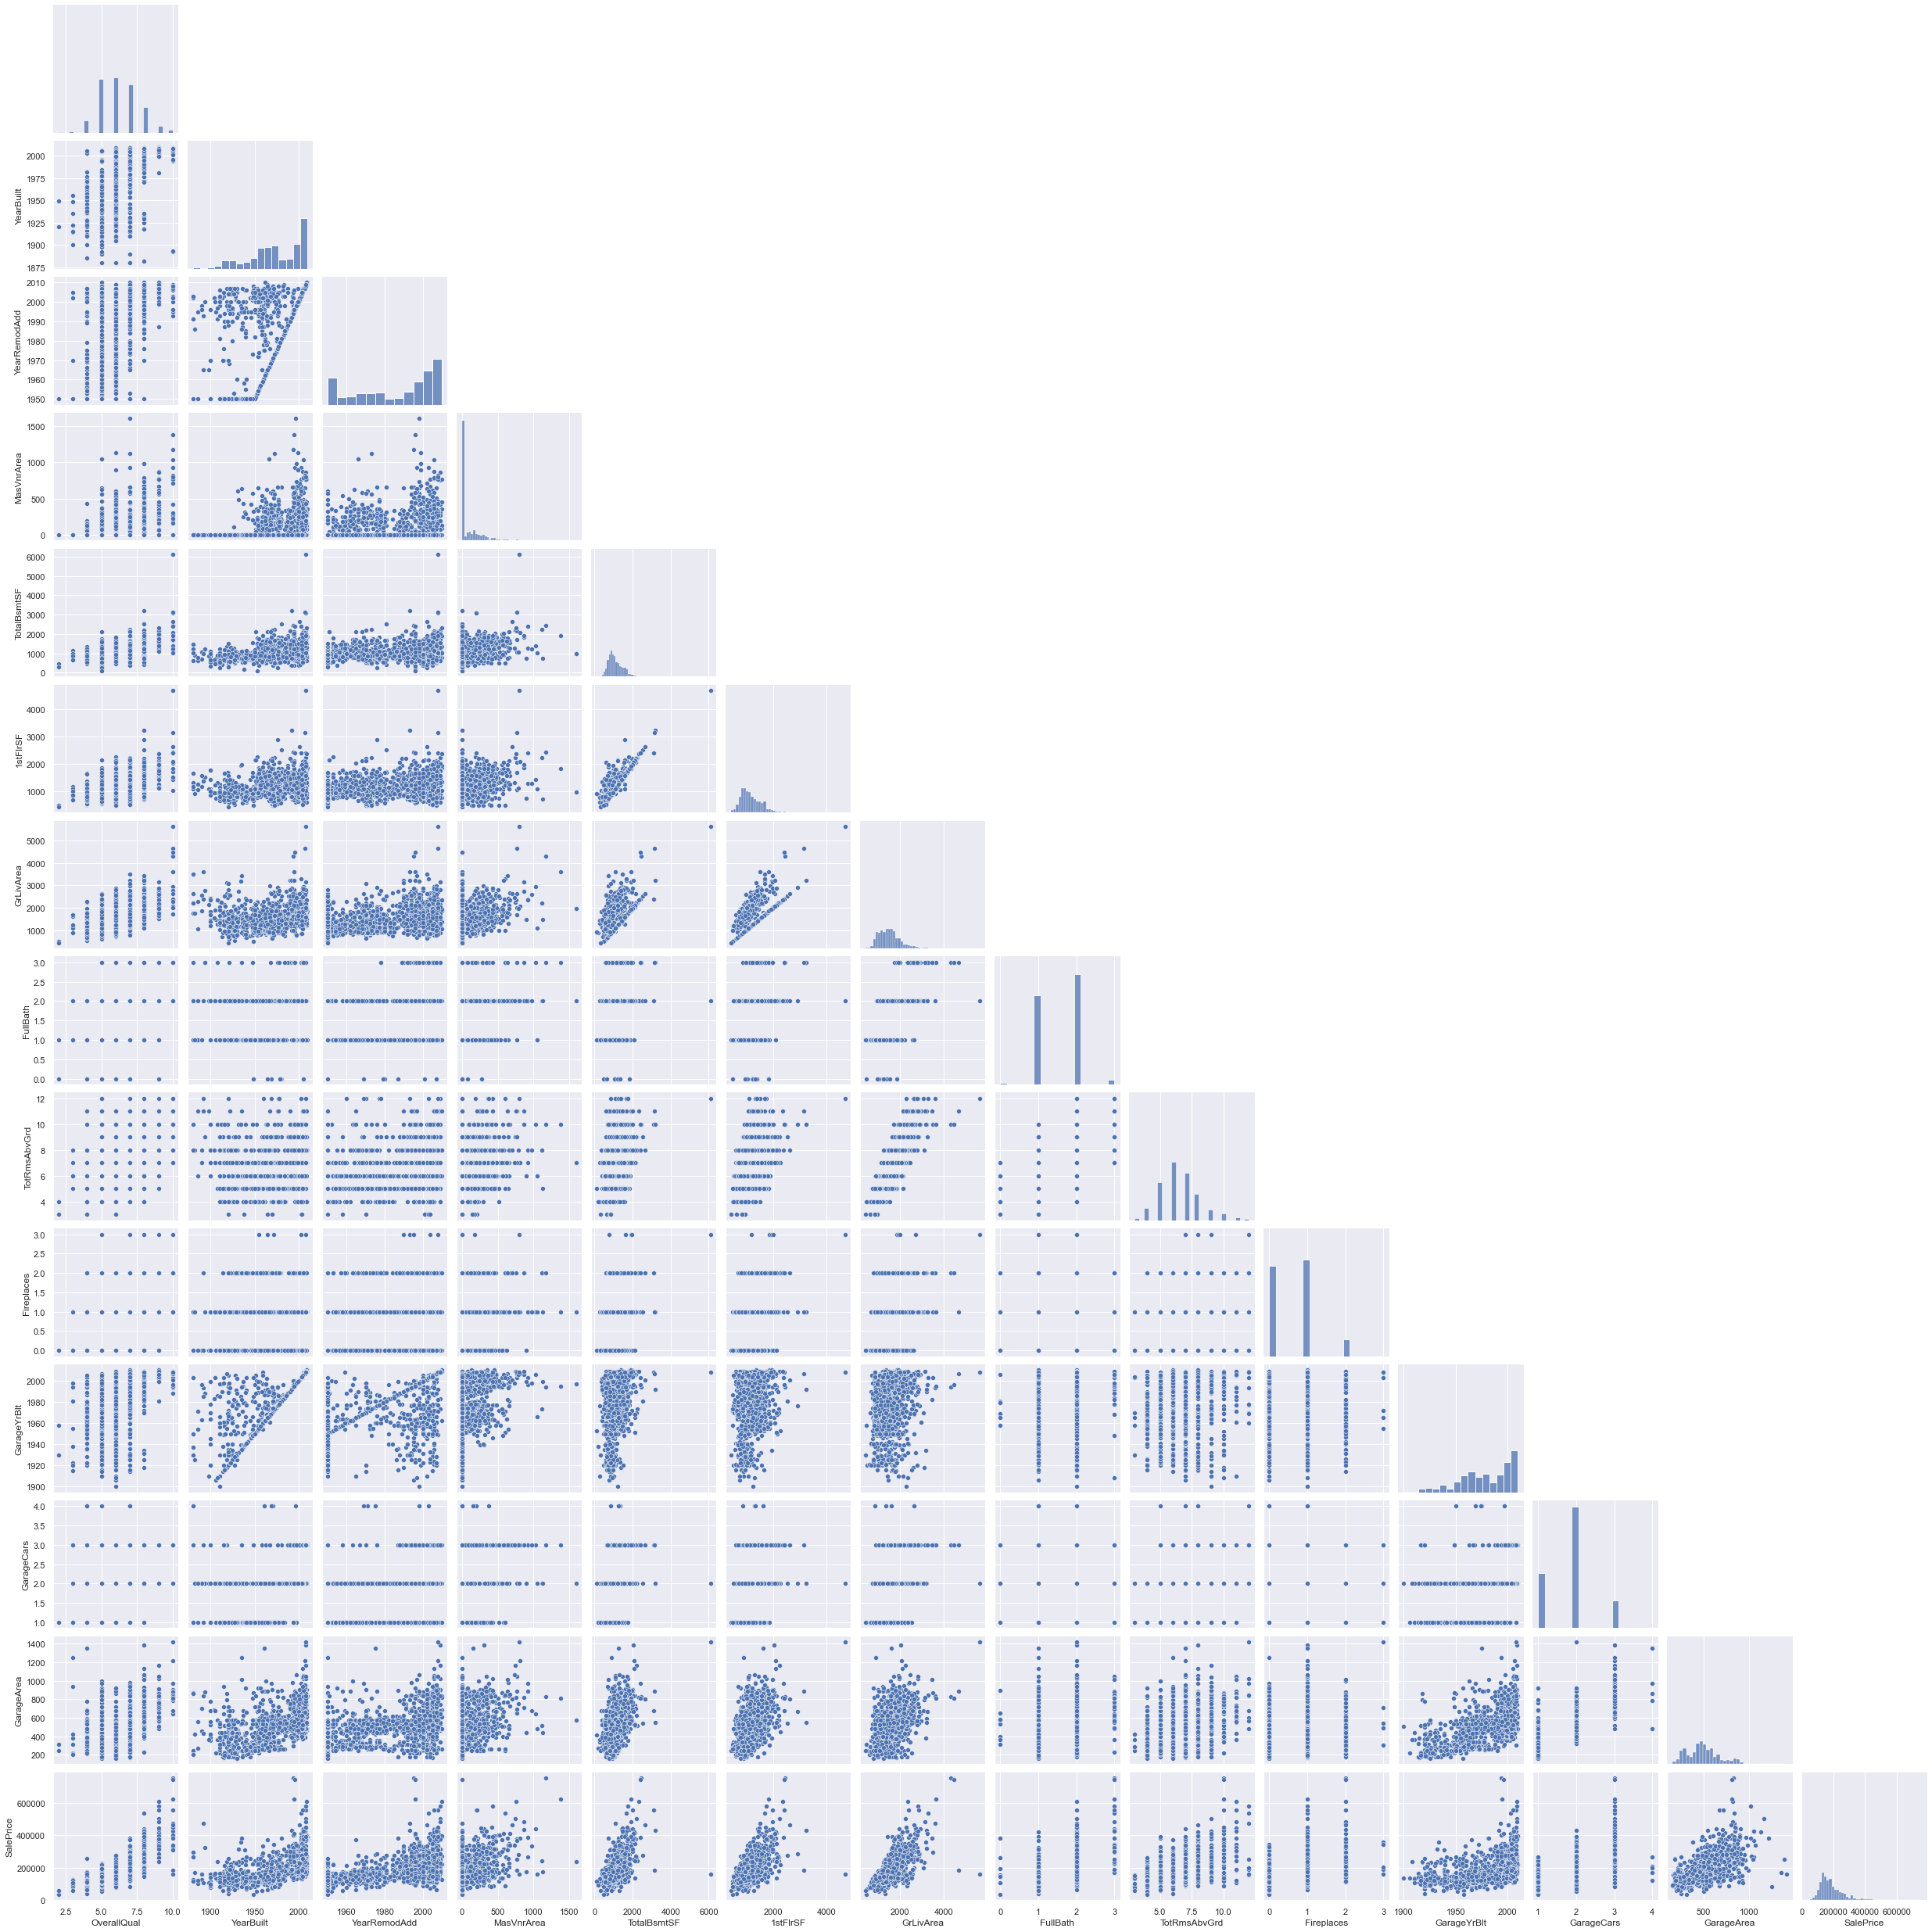

In [169]:
sns.set()

sns.pairplot(X[updatedCorrelation], height = 2.5, corner = True)

plt.show

Algumas categorias são interessantes de analisar: *1stFlrSF* se relaciona com *SalePrice* formando algo como uma exponencial, indicando que, quanto maior a área do primeiro andar, mais caro uma casa pode ser vendida, crescendo de maneira abrupta a partir de um valor. *GrLivArea* e *TotalBsmtSF* se comportam de maneira parecida. 

Já *YearBuilt*, *YearRemodAdd*, *GarageYrBlt* e *GarageArea* se comportam de maneira similar à uma fórmula linear, mantendo um crescimento constante em relação ao aumento do preço da casa. 

As *features* categóricas (*OverallQual*, *FullBath*, *TotRmsAbvGrd*, *Fireplaces* e *GarageCars*) tem um crescimento mais linear.

## Procurando por *outliers*

Baseando-se na análise feita dos gráficos relacionados à categoria *SalePrice* e a forma como os dados são exibidos entre si, pode-se analisar o quanto cada elemento do conjunto de dados é relevante para a construção do modelo regressor. 



### Análise univariada
Antes de analisarmos os dados comparando com *SalePrice*, um bom caminho a seguir é primeiro padronizar os dados desta coluna. Padronizando os dados, a média tende a 0, com um desvio padrão esperado de 1 (ou seja, variando entre -1 e 1).

In [170]:
saleprice_scaled = StandardScaler().fit_transform(np.array(X['SalePrice'])[:,np.newaxis])

low_range  = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.91990905]
 [-1.8604676 ]
 [-1.65772778]
 [-1.62594708]
 [-1.6069319 ]
 [-1.6069319 ]
 [-1.57672312]
 [-1.54988636]
 [-1.52453279]
 [-1.5181944 ]]

outer range (high) of the distribution:
[[3.78070184]
 [3.99414088]
 [4.45257146]
 [4.66807681]
 [4.68811881]
 [5.02217745]
 [5.38630543]
 [5.55545178]
 [7.07666601]
 [7.20343387]]


Valores em "low_range" indicam os primeiros 10 valores, sendo estes não tão longe de 0, indicando que não existem muitos valores como *outliers* menores que a média.

Valores em "high_range" são os 10 últimos em *SalePrice*, que variam até 7 ou mais, indicando uma **grande** variação. 

Agora, analisaremos os gráficos das *features* correlacionadas à *SalePrice*.


### Análise bivariada


#### Começando com os gráficos de *features* numéricas e analisado sua distribuição em relação à *SalePrice*.

Para criar os gráficos, as categorias numéricas serão ordenadas em relação à correlação com *SalePrice*. 

In [171]:
numFeatures = ['GrLivArea', 'YearBuilt', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GarageYrBlt', 'GarageArea']

numValues = [corrDict[key] for key in numFeatures]

numValues.sort(reverse = True)

sortedNumFeatures = [key for key in sorted(corrDict, key = corrDict.get, reverse = True) if key in numFeatures]

[print('{}: {}'.format(sortedNumFeatures[i], '{:.2}'.format(numValues[i]))) for i in range(len(numFeatures))]

GrLivArea: 0.71
GarageArea: 0.62
TotalBsmtSF: 0.61
1stFlrSF: 0.61
YearBuilt: 0.52
GarageYrBlt: 0.49
MasVnrArea: 0.48


[None, None, None, None, None, None, None]

1338


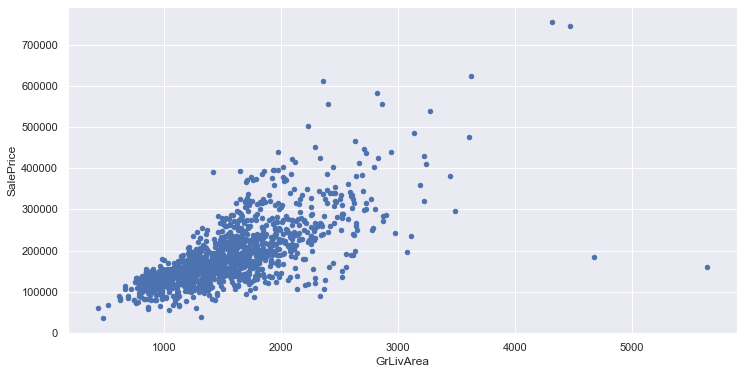

In [172]:
X.plot.scatter(x = 'GrLivArea', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

print(X.shape[0])

A representação dos elementos mais acima (com *SalePrice* > 700.000) são os elementos com a variação > 7. Estes elementos seguem o padrão que outros elementos representam, algo como uma função linear.

Já os elementos mais a esquerda (com *GrLivArea* > 4500) são elementos considerados *outliers*, sendo assim, removê-los é beneficial para o modelo regressor ter uma precisão maior.

In [177]:
outliers = []

[outliers.append(index) for index, value in enumerate(X['GrLivArea']) if value >= 4500]

X.drop(index = outliers, inplace = True)

523 4676
1298 5642
[523, 1298]
1983


Após esta remoção de elementos, os próximos gráficos se mantém dentro de um padrão, sem muitos *outliers*.

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

<Figure size 864x432 with 0 Axes>

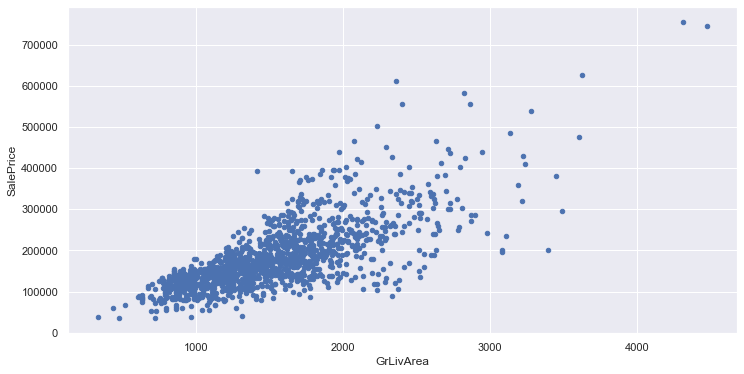

In [187]:
X.plot.scatter(x = 'GrLivArea', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

A partir dessa remoção, as outras *features* não apresentam mais *outliers*.

### *Feature*: "TotalBsmtSF"

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

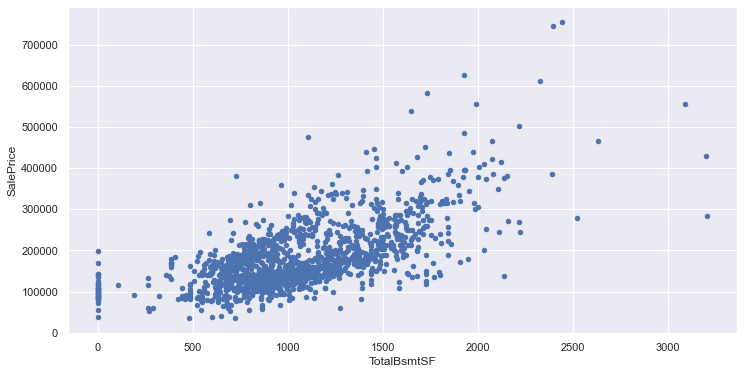

In [188]:
 X.plot.scatter(x = 'GrLivArea', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

)

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

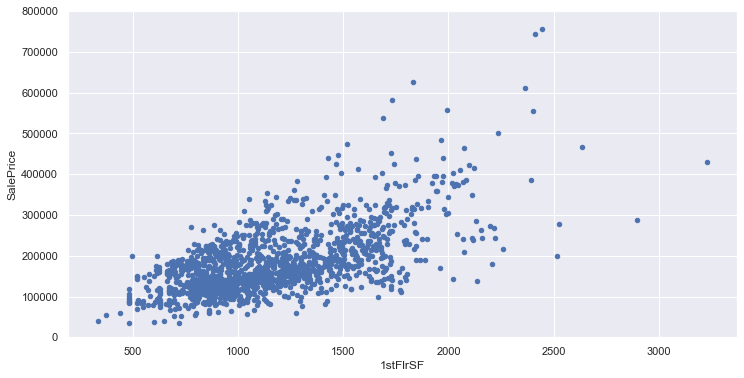

In [189]:
X.plot.scatter(x = '1stFlrSF', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

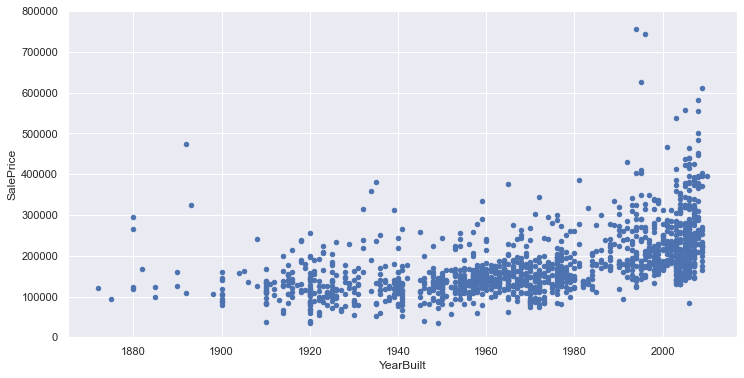

In [190]:
X.plot.scatter(x = 'YearBuilt', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

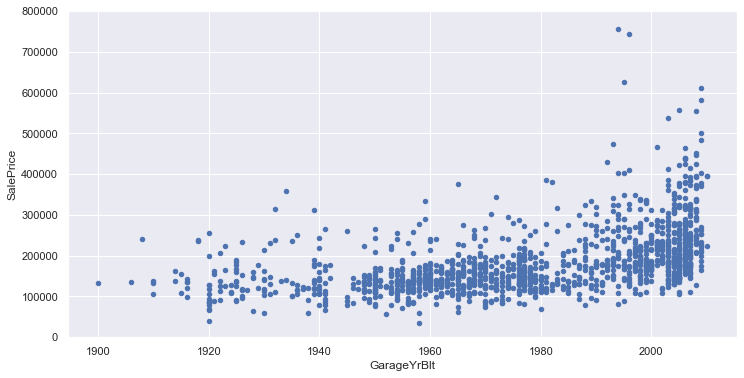

In [191]:
X.plot.scatter(x = 'GarageYrBlt', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

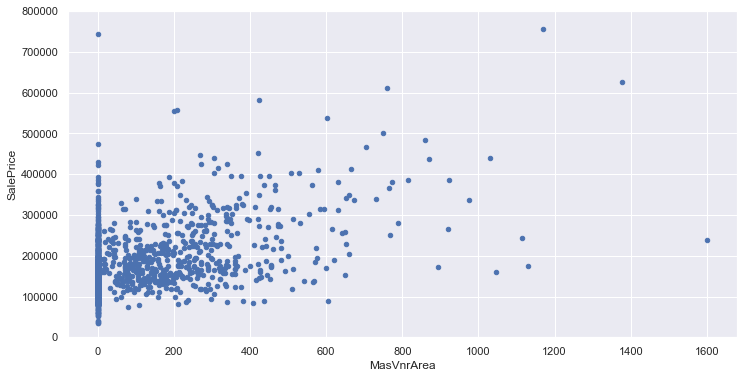

In [192]:
X.plot.scatter(x = 'MasVnrArea', y = 'SalePrice', color = '#4C72B0', ylim=(0,800000))

#### Continuando com os gráficos de *features* categóricas.

In [94]:
catFeatures = ['OverallQual', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']

catValues = [corrDict[key] for key in catFeatures]

catValues.sort(reverse = True)

sortedCatFeatures = [key for key in sorted(corrDict, key = corrDict.get, reverse = True) if key in catFeatures]

[print('{}: {}'.format(sortedCatFeatures[i], "{:.2}".format(catValues[i]))) for i in range(len(catFeatures))]

OverallQual: 0.79
FullBath: 0.56
TotRmsAbvGrd: 0.53
Fireplaces: 0.47


[None, None, None, None]

Com o diagrama de caixa, podemos ver melhor as *features* categóricas e seus *outliers* de maneira mais clara. Em cada *feature*, pode-se ver que praticamente todas têm um ou mais *outliers*. Para melhorar a precisão do regressor, deve-se analisar caso a caso, a fim de decidir entre removê-los, se fugirem muito do padrão, ou mantê-los, caso sigam a ideia do conjunto de dados.

In [201]:
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats

(-0.5, 9.5, 0.0, 800000.0)

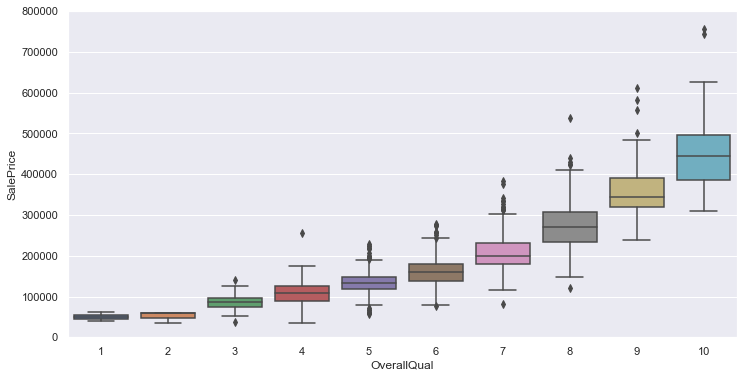

In [199]:
data = pd.concat([X['SalePrice'], X['OverallQual']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 3.5, 0.0, 800000.0)

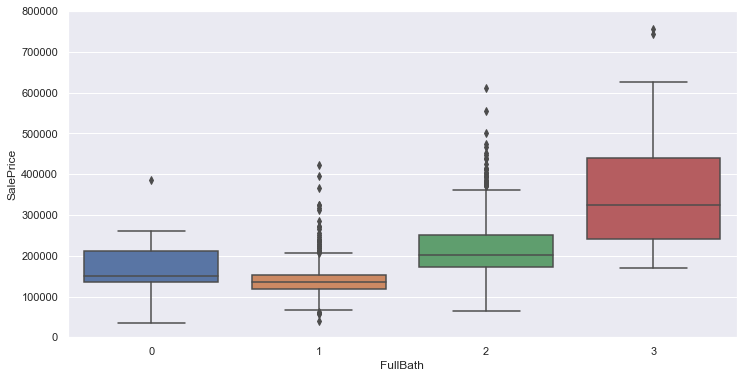

In [96]:
data = pd.concat([X['SalePrice'], X['FullBath']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'FullBath', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 9.5, 0.0, 800000.0)

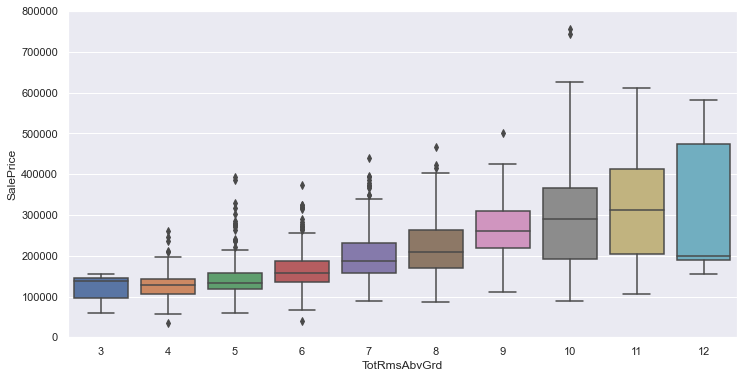

In [97]:
data = pd.concat([X['SalePrice'], X['TotRmsAbvGrd']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'TotRmsAbvGrd', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 3.5, 0.0, 800000.0)

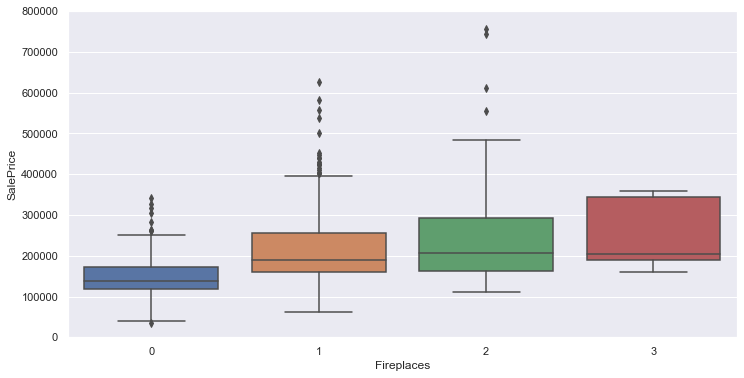

In [98]:
data = pd.concat([X['SalePrice'], X['Fireplaces']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'Fireplaces', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

## Análise mais detalhada de das *features*


### Criando gráficos das *features* para checar a distribuição
Com o histograma e o gráfico de probabilidade dos dados gerado, é possível analisar melhor o formato das *features*. 

#### *SalePrice*

Nota-se, no histograma, que a distribuição dos mesmos foge da distribuição normal, tendo uma assimetria positiva, indicando que existem mais elementos maiores que o pico da função de distribuição. O valor positivo da curtose indica uma curva leptocúrtica, que representa o quão fácil é encontrar elementos do *dataset* que fogem da média.

Assimetria: 1.9501175148749574
Curtose: 6.874544436829373


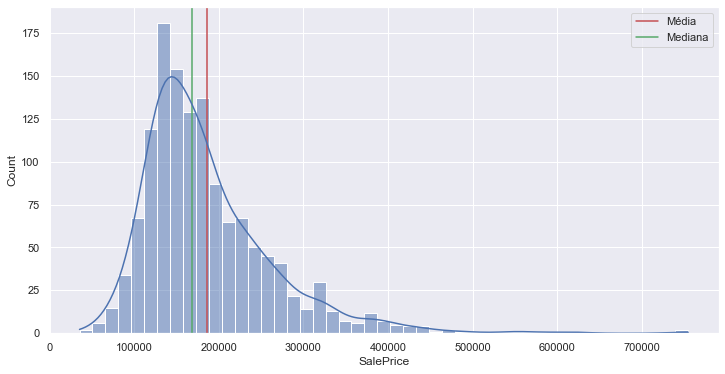

In [99]:
createHistPlot(X['SalePrice'])

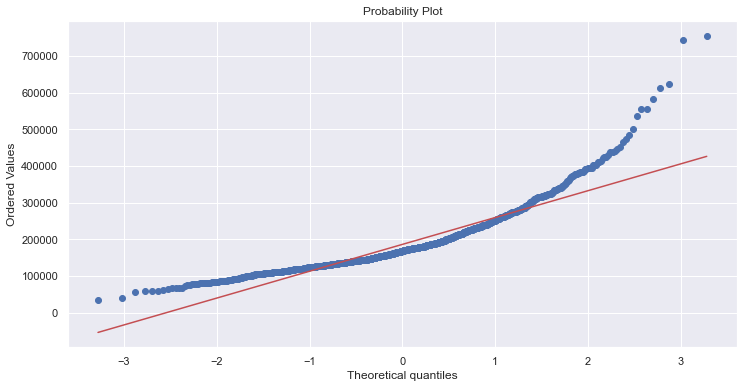

In [100]:
createProbPlot(X['SalePrice'])

Como dito anteriormente, assimetria > 0 indica que o a *feature*-alvo *SalePrice* precisa ser normalizada.

In [101]:
X['SalePrice'] = np.log(X['SalePrice'])

Assimetria: 0.2901735127573945
Curtose: 0.764726032318467


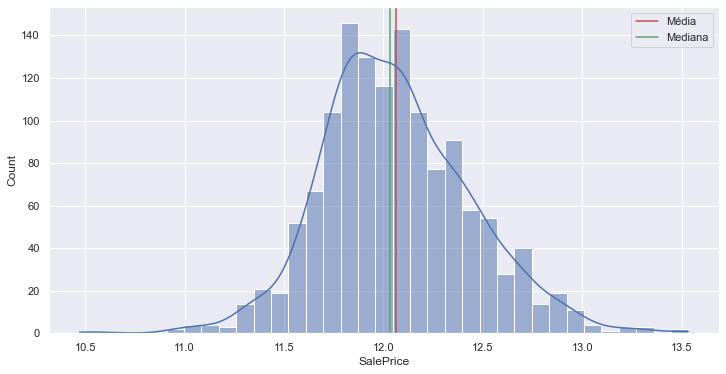

In [102]:
createHistPlot(X['SalePrice'])

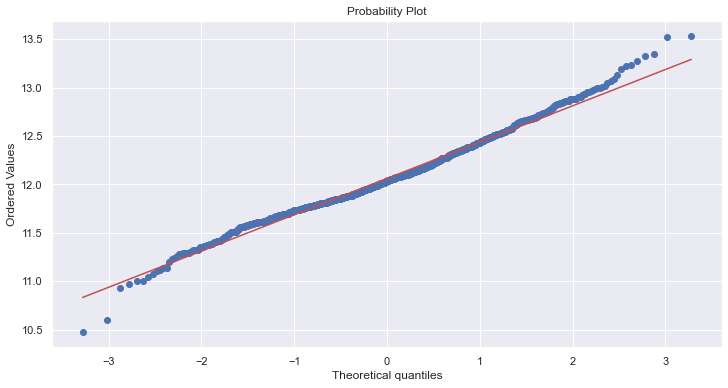

In [103]:
createProbPlot(X['SalePrice'])

#### Outras *features*

Dado que *SalePrice* não estava distribuido normalmente, deve-se checar as outras *features* e normalizá-las, caso necessário. 

##### *GrLivArea*


Assimetria: 1.4312416801524221
Curtose: 5.318869887933019


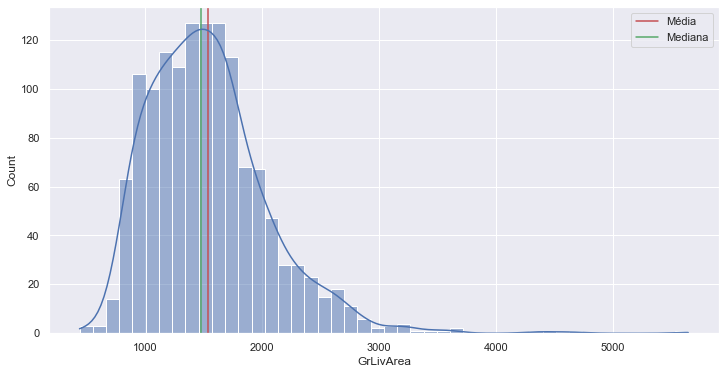

In [104]:
createHistPlot(X['GrLivArea'])

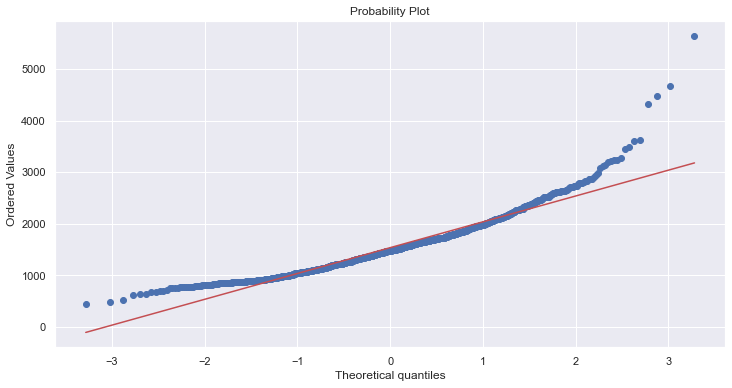

In [105]:
createProbPlot(X['GrLivArea'])

Como em *SalePrice*, é aplicado a transformação nos dados.

In [106]:
X['GrLivArea'] = np.log(X['GrLivArea'])

Assimetria: 0.06912845319774326
Curtose: 0.2189454728386271


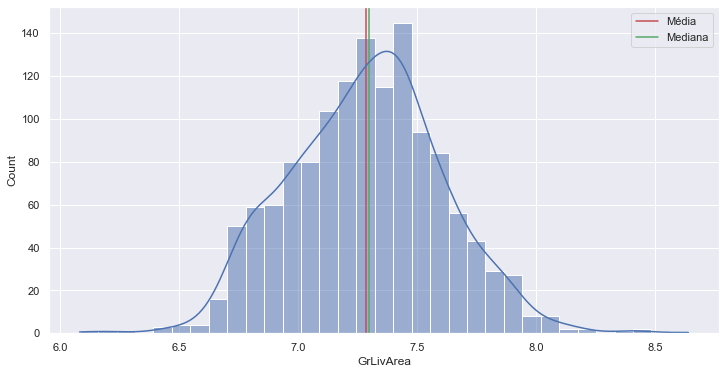

In [107]:
createHistPlot(X['GrLivArea'])

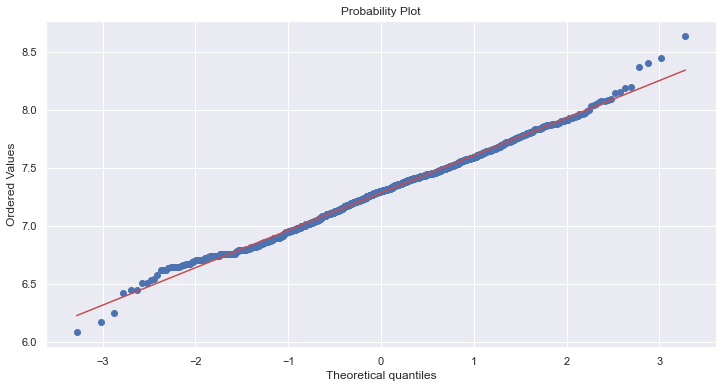

In [108]:
createProbPlot(X['GrLivArea'])

##### *GarageArea*

Assimetria: 0.8085137750089764
Curtose: 1.1833087550063501


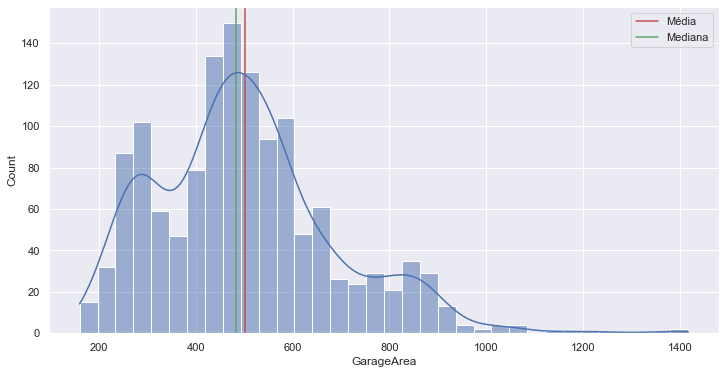

In [109]:
createHistPlot(X['GarageArea'])

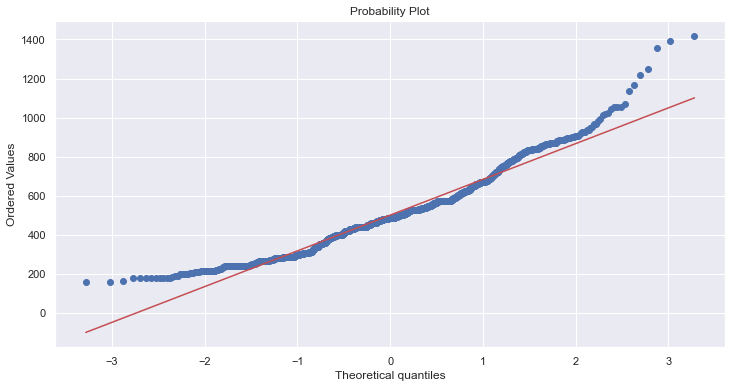

In [110]:
createProbPlot(X['GarageArea'])

Um problema encontrado: uma grande quantidade de elementos com valor igual a 0, representando uma casa sem garagem (área de garagem = 0). A transformação utilizando log não pode ser executada com valores iguais a 0, então, é preciso improvisar.

É então, adicionado uma nova coluna no *dataset*, indicando quais elementos do mesmo possuem garagem: se a área da garagem é maior que 0, o elemento possui garagem, senão, não possui.

In [111]:
X['HasGarage'] = pd.Series(len(X['GarageArea']), index=X.index)
X['HasGarage'] = 0 
X.loc[X['GarageArea'] > 0,'HasGarage'] = 1

É, então, feito a transformação linear nos elementos que possuem garagem.

In [112]:
X.loc[X['GarageArea'] == 1,'GarageArea'] = np.log(X['GarageArea'])

In [113]:
lista = X[X['GarageArea'] > 0 ]['GarageArea']

Assimetria: 0.8085137750089764
Curtose: 1.1833087550063501


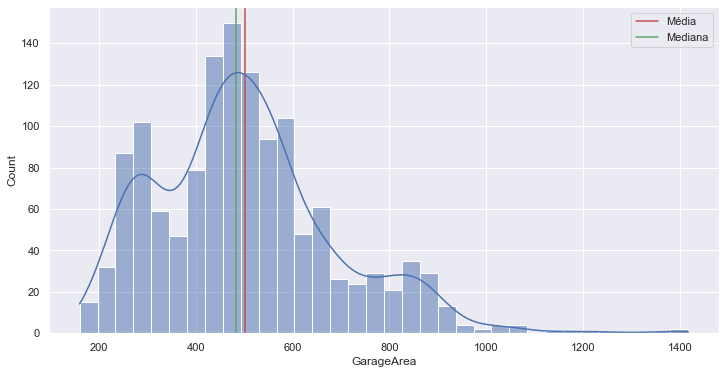

In [114]:
createHistPlot(lista)

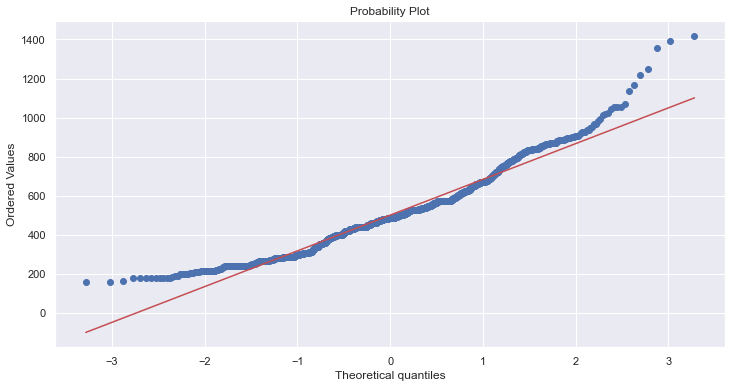

In [115]:
createProbPlot(lista)

O resultado não é dos melhores, mas é o que foi possível obter.

##### *TotalBsmtSF*

Assimetria: 2.219579555674883
Curtose: 18.44956420704582


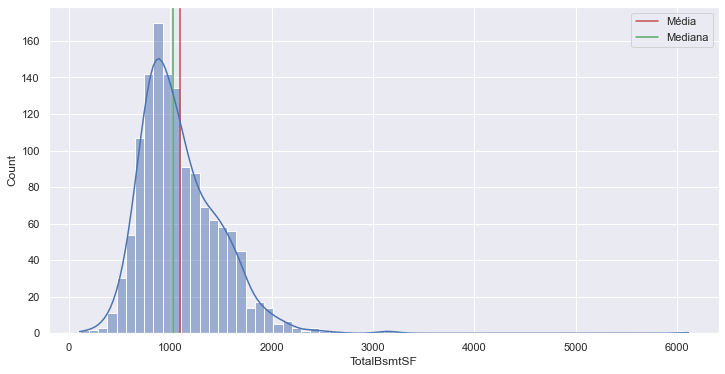

In [116]:
createHistPlot(X['TotalBsmtSF'])

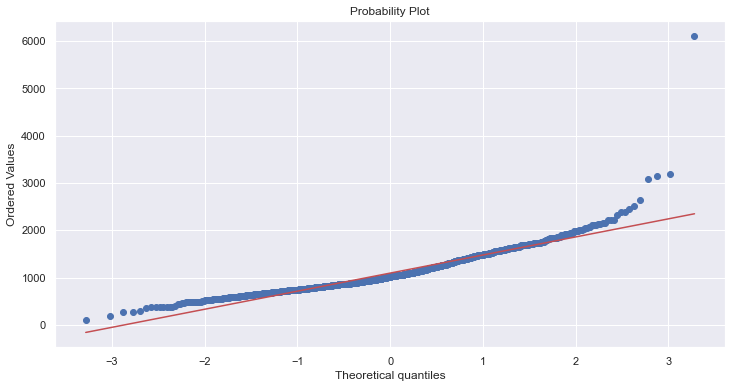

In [117]:
createProbPlot(X['TotalBsmtSF'])

Nessa *feature*, podemos ver que existem elementos com valor igual a 0, logo, é necessário fazer o mesmo processo realizado na *feature* anterior.

In [118]:
X['HasBsmt'] = pd.Series(len(X['TotalBsmtSF']), index=X.index)
X['HasBsmt'] = 0 
X.loc[X['TotalBsmtSF'] > 0,'HasBsmt'] = 1

In [119]:
X.loc[X['TotalBsmtSF'] == 1,'TotalBsmtSF'] = np.log(X['TotalBsmtSF'])

In [120]:
lista = X[X['TotalBsmtSF'] > 0 ]['TotalBsmtSF']

Assimetria: 2.219579555674883
Curtose: 18.44956420704582


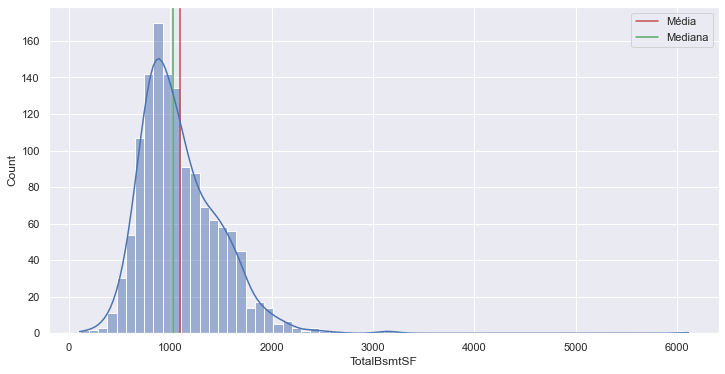

In [121]:
createHistPlot(lista)

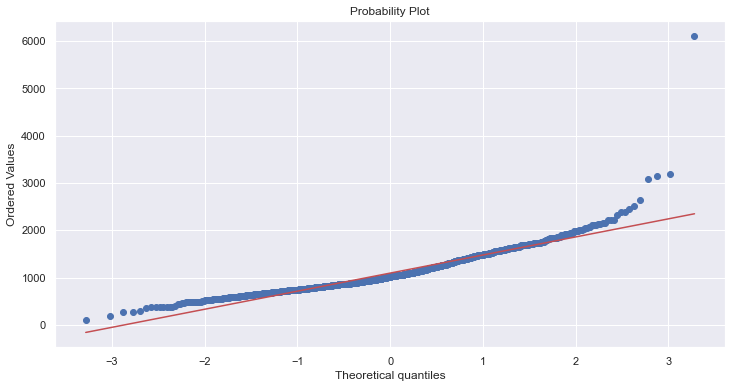

In [122]:
createProbPlot(lista)

##### *1stFlrSF*

Assimetria: 1.400702468965983
Curtose: 6.088158203715096


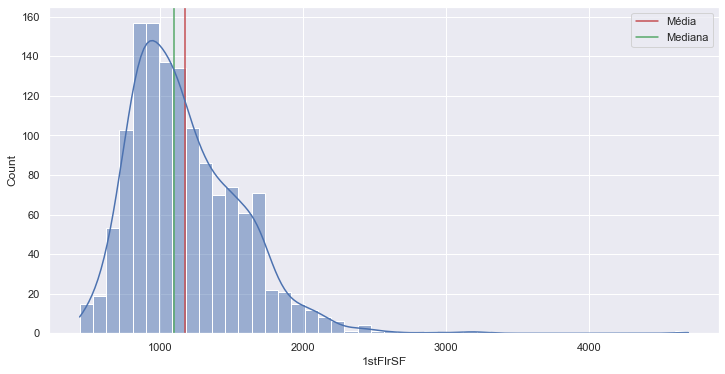

In [123]:
createHistPlot(X['1stFlrSF'])

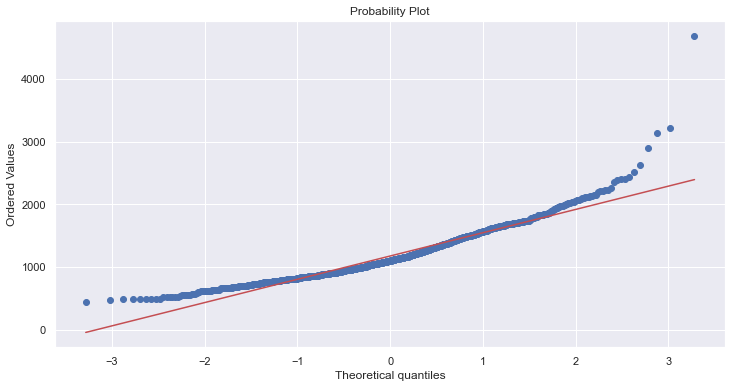

In [124]:
createProbPlot(X['1stFlrSF'])

Com a assimetria e a curtose se distanciando de 0, aplica-se a transformação.

In [125]:
X['1stFlrSF'] = np.log(X['1stFlrSF'])

Assimetria: 0.10294153909807774
Curtose: 0.06654419170703596


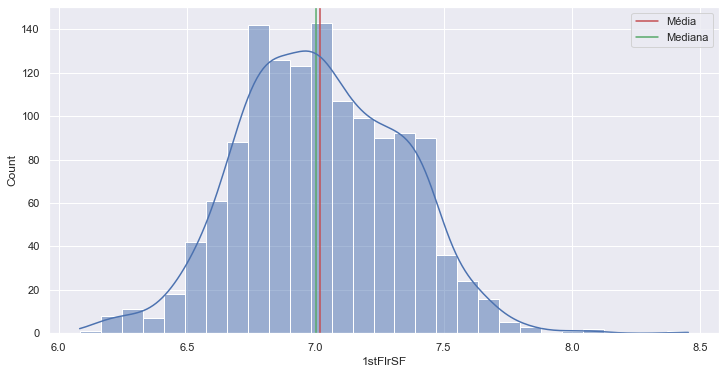

In [126]:
createHistPlot(X['1stFlrSF'])

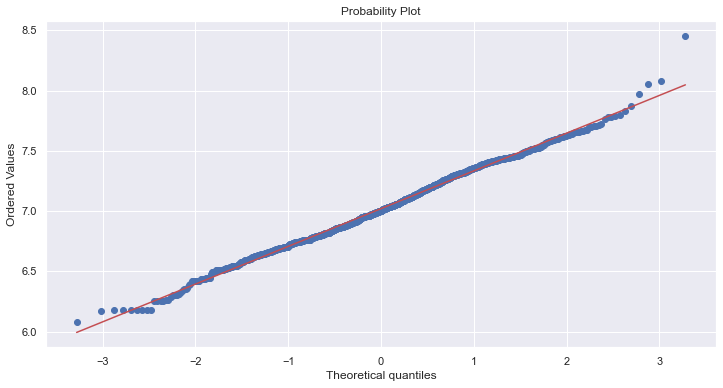

In [127]:
createProbPlot(X['1stFlrSF'])

##### *YearBuilt*

Assimetria: -0.6759804686684152
Curtose: -0.33931405983942


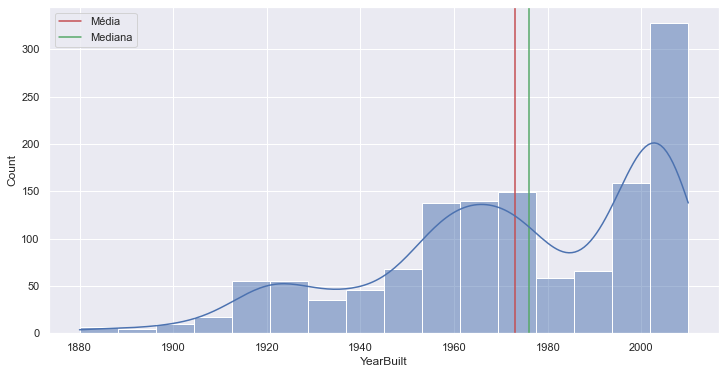

In [128]:
createHistPlot(X['YearBuilt'])

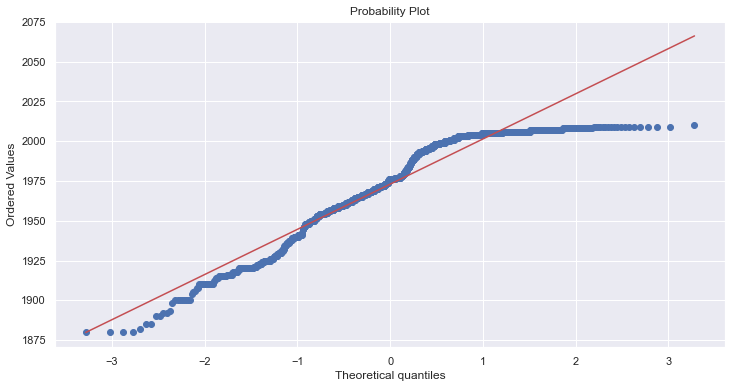

In [129]:
createProbPlot(X['YearBuilt'])

Apesar da aparência do gráfico, a assimetria e a curtose estão relativamente próximas do ideal valor 0, indicando que, talvez, realizar a transformação dos dados não traga um ganho.

##### *GarageYrBlt*

Assimetria: -0.6673698272543725
Curtose: -0.3940160990289434


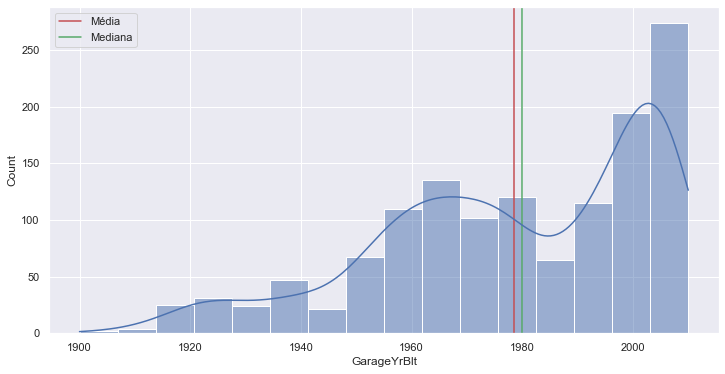

In [130]:
createHistPlot(X['GarageYrBlt'])

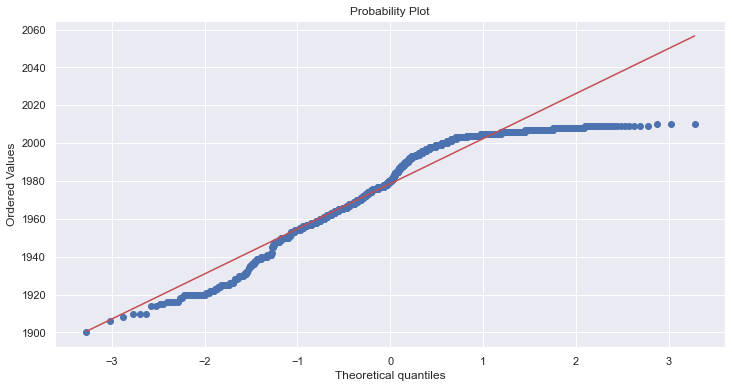

In [131]:
createProbPlot(X['GarageYrBlt'])

Assim como a *feature YearBuilt*, *GarageYrBlt* não tem uma assimetria e curtose longe de 0, e, com uma transformação, o resultado não deve melhorar.

##### *MasVnrArea*

Assimetria: 2.5924673714031212
Curtose: 9.538893848388993


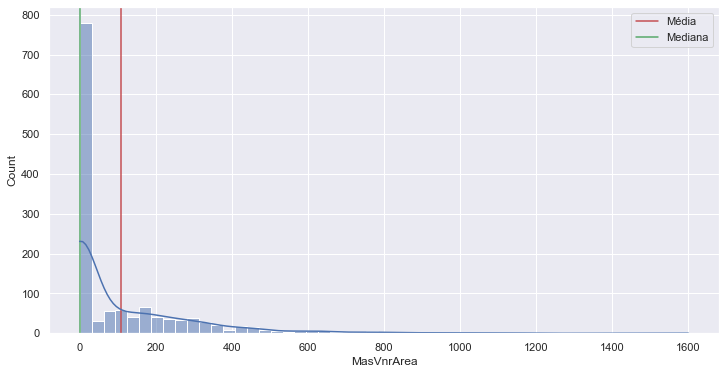

In [132]:
createHistPlot(X['MasVnrArea'])

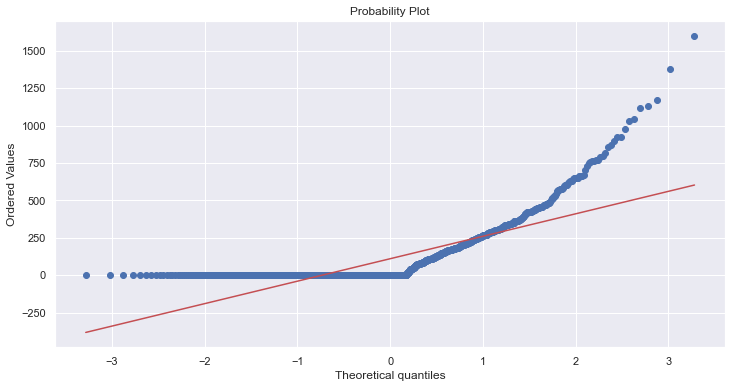

In [133]:
createProbPlot(X['MasVnrArea'])

Dado a grande ocorrência de 0 nessa *feature*, tentar transformar para melhorar a distribuição não vai melhorar o resultado.

## Por fim, é gerado as variáveis *dummy*

In [134]:
X = pd.get_dummies(X)

## Agora, finalmente, os dados estão prontos para serem utilizados por um algoritmo regressor.

In [135]:
X_Test = pd.read_csv('test.csv')

In [136]:
X_Test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [137]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [138]:
X

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,196.00,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,0.00,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,162.00,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,0.00,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,350.00,655,0,490,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0.00,0,0,953,...,0,0,0,1,0,0,0,0,1,0
1456,20,13175,6,6,1978,1988,119.00,790,163,589,...,0,0,0,1,0,0,0,0,1,0
1457,70,9042,7,9,1941,2006,0.00,275,0,877,...,0,0,0,1,0,0,0,0,1,0
1458,20,9717,5,6,1950,1996,0.00,49,1029,0,...,0,0,0,1,0,0,0,0,1,0


In [139]:
model = RandomForestRegressor()

X.dropna(axis = 0, inplace = True)

Y = X['SalePrice']

X.drop('SalePrice', axis = 1, inplace = True)

In [140]:
X.isnull().sum()

MSSubClass               0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 266, dtype: int64

In [141]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.5)

model.fit(X_Train, Y_Train)

res = model.predict(X_Test)

In [142]:
from sklearn.metrics import explained_variance_score

In [143]:
print(explained_variance_score(Y_Test, res, multioutput='raw_values'))

[0.85348213]
